# Initial Model Testing with new Sequence Generator

In [97]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

#Keras
from tensorflow import keras
from tensorflow import stack, Tensor

from keras import Sequential, layers

from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop

from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from keras.utils import timeseries_dataset_from_array


from tensorflow import data



#Project imports 
from bdi_predict.model.data import clean_data
from bdi_predict.model.preprocessor import train_val_test_split, min_max_scaler
from bdi_predict.model.sequencer import SequenceGenerator
from bdi_predict.model.params import BASE_PROJECT_PATH


In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing - (splitting data, scaling, and creating sequences)

In [69]:
df = pd.read_csv("../data/cleaned_data.csv")
df = df.drop(columns="log_BDRY").copy()
df.set_index("time", inplace=True)
df.head(3)

,BDRY,BDI,target
time,,,
2018-03-23,24.1005,1122.0,-0.024735
2018-03-26,24.8400,1126.0,0.013126
2018-03-27,24.0800,1117.0,-0.013495


In [70]:
dfs = train_val_test_split(df=df, train_val_test_ratio=(7,2,1))

Data split into train, validation, and test datasets.


In [71]:
df_train, df_val, df_test = min_max_scaler(dfs=dfs)

Datasets min-max scaled.


In [72]:
df_train.head(3)

,BDRY,BDI,target
0,0.769748,0.240992,0.337520
1,0.797941,0.242314,0.531249
2,0.768967,0.239339,0.395035


In [73]:
df_val.head(3)

,BDRY,BDI,target
0,0.865040,0.984463,0.453253
1,0.858178,0.984463,0.448999
2,0.880671,0.985785,0.513167


In [74]:
df_test.head(3)

,BDRY,BDI,target
0,0.462066,0.598678,0.417447
1,0.488753,0.592727,0.559068
2,0.505528,0.610579,0.521776


In [75]:
#Instantiating a SequenceGenerator Class

Sequencer = SequenceGenerator(input_width=20,
                                      target_width=1,
                                      offset=1,
                                      df_train=df_train,
                                      df_val=df_val,
                                     df_test=df_test,
                                     target_columns=["target"])

Sequencer

Total sequence size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Target indice(s): [20]
Target column name(s): ['target']

In [76]:
len(df_train)

782

In [77]:
Sequencer.total_sequence_size

21

In [78]:
Sequencer.target_width

1

## Testing out the Sequence

In [79]:
example_sequence = stack([np.array(df_train[:Sequencer.total_sequence_size]),
                           np.array(df_train[100:100+Sequencer.total_sequence_size]),
                           np.array(df_train[200:200+Sequencer.total_sequence_size])])
example_sequence.shape

TensorShape([3, 21, 3])

In [80]:
example_sequence[0, 2, 2]

<tf.Tensor: shape=(), dtype=float64, numpy=0.39503531854439916>

In [81]:
# Inputting a tf.Tensor made up of 3 slices 
#(the 3 sequenecs that make up a single batch of batch_size=3) to generate

# Stack 3 slices, the length of the total window.
# FIX THIS!

example_inputs, example_targets = Sequencer.split_sequence(example_sequence)

print('All shapes are: (batch, time, features)')
print(f'Sequence shape: {example_sequence.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'targets shape: {example_targets.shape}')

#Desired shapes
#Sequence shape: (3, 21, 2)
#Inputs Shape: (3, 20, 2)
# target shape: (3, 1, 1)

All shapes are: (batch, time, features)
Sequence shape: (3, 21, 3)
Inputs shape: (3, 20, 3)
targets shape: (3, 1, 1)


In [82]:
train = Sequencer.train 

In [83]:
type(train)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [84]:
# "The Dataset.element_spec property tells you the structure, data types, and shapes of the dataset elements."

train.element_spec

(TensorSpec(shape=(None, 20, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))

In [85]:
for example_inputs, example_targets in Sequencer.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_targets.shape}')

Inputs shape (batch, time, features): (32, 20, 3)
Labels shape (batch, time, features): (32, 1, 1)


# Training the Model

In [91]:
def init_model():
    
    """ 
    Initialize the LSTM Reucrrent Neural Network.
    """
    
    print("\nInitialising model...")
    
    model = Sequential()

    #LSTM LAYERS:
    
    model.add(layers.LSTM(60,
                          activation="tanh",
                          input_shape=(20,3),
                          return_sequences=False))

    #DENSE LAYERS:
    
    model.add(layers.Dense(25, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))
    
    print("\nmodel initialized.")

    #SETTING UP OPTIMIZERS:
    
    lr_schedule = ExponentialDecay(initial_learning_rate=1e-3,
                                   decay_steps=10000,
                                   decay_rate=0.9)
    
    rmsprop = RMSprop(learning_rate=lr_schedule)
    
    #COMPILING MODEL:
    
    model.compile(loss="mse",
                  optimizer=rmsprop,
                  metrics="mae")
    print("\nmodel compiled.")
    

    return model

In [92]:
def train_model(model,
                sequence_generator,
                patience=10):
    
    """
    Fit model and return a the tuple (fitted_model, history)
    """
    
    print("\nTraining model...")
    
    
    #EarlyStopping DEFINITION:
    
    es = EarlyStopping(monitor="val_mae",
                       patience=patience,
                       restore_best_weights=True)
    
    #FITTING MODEL:
    
    history = model.fit(sequence_generator.train,
                        epochs=100,
                        validation_data=sequence_generator.val,
                        shuffle=True,
                        callbacks=es)
    
    
     
    return model, history

In [93]:
lstm_model = init_model()


Initialising model...

model initialized.

model compiled.


In [94]:
model, history = train_model(lstm_model, Sequencer, patience=10)


Training model...
Epoch 1/100


2022-12-22 17:03:41.950140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 17:03:42.132919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 17:03:44.501078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 0.2089 - mae: 0.4471

2022-12-22 17:03:46.381952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 17:03:46.440280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 6s 51ms/step - loss: 0.2089 - mae: 0.4471 - val_loss: 0.1936 - val_mae: 0.4261
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.1861 - mae: 0.4210 - val_loss: 0.1739 - val_mae: 0.4023
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 0.1668 - mae: 0.3975 - val_loss: 0.1555 - val_mae: 0.3788
Epoch 4/100
24/24 [==============================] - 0s 14ms/step - loss: 0.1487 - mae: 0.3740 - val_loss: 0.1383 - val_mae: 0.3555
Epoch 5/100
24/24 [==============================] - 0s 14ms/step - loss: 0.1318 - mae: 0.3507 - val_loss: 0.1223 - val_mae: 0.3324
Epoch 6/100
24/24 [==============================] - 0s 14ms/step - loss: 0.1160 - mae: 0.3276 - val_loss: 0.1073 - val_mae: 0.3093
Epoch 7/100
24/24 [==============================] - 0s 14ms/step - loss: 0.1013 - mae: 0.3042 - val_loss: 0.0936 - val_mae: 0.2866
Epoch 8/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0878 - mae: 

In [98]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # Loss:MSE
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # Metrics:MAE
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

array([<AxesSubplot: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

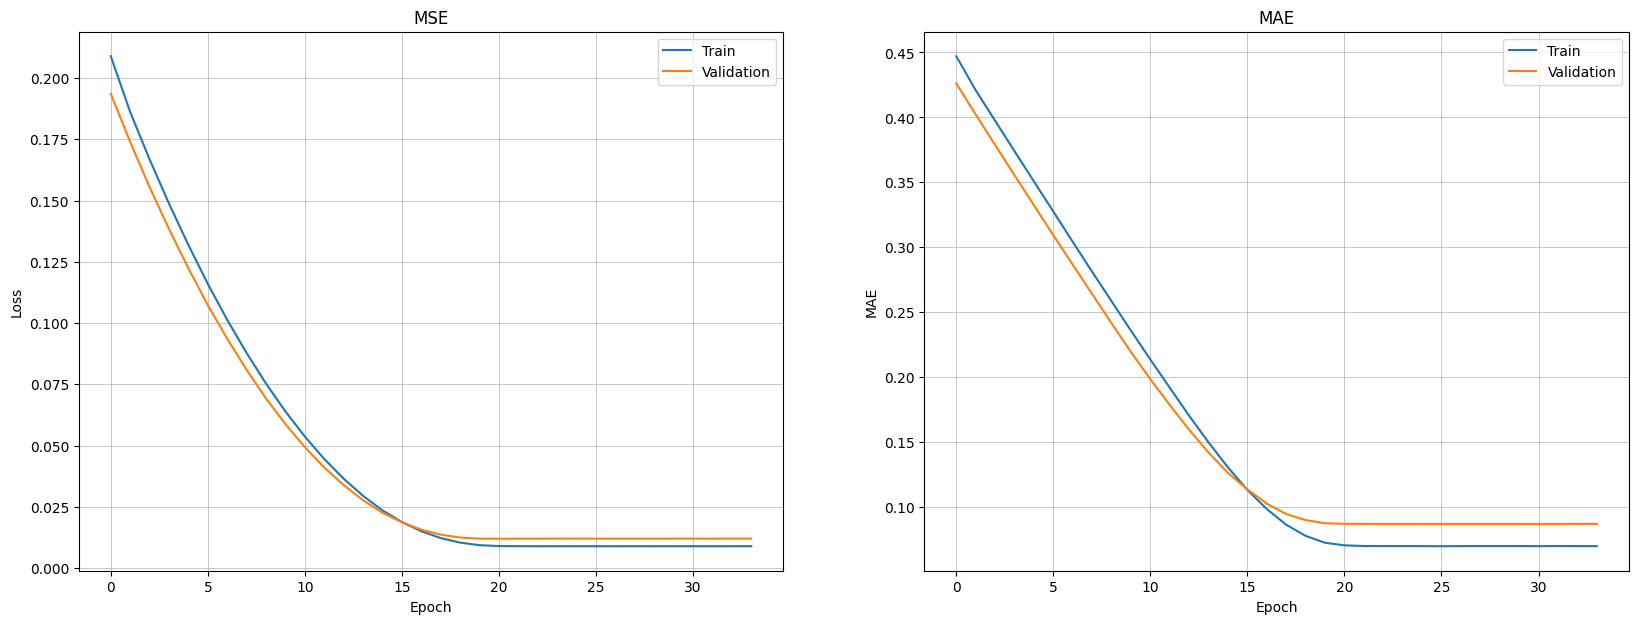

In [99]:
plot_history(history)